In [1]:
import pandas as pd
import numpy as np

In [2]:
!gdown --id 1BW9yZtqryEJuNQ80cJQ9YJQuKS6YKJFT

Downloading...
From: https://drive.google.com/uc?id=1BW9yZtqryEJuNQ80cJQ9YJQuKS6YKJFT
To: /content/2110446-data-science-and-data-engineering-2021.zip
161MB [00:01, 88.0MB/s]


In [3]:
!unzip 2110446-data-science-and-data-engineering-2021.zip

Archive:  2110446-data-science-and-data-engineering-2021.zip
  inflating: DS_kaggle_edited_v3/Bangkok/Test/3H_temperature_Bangkok.csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Test/3H_wind_Bangkok.csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Test/Bangkok (Thailand timezone).csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Train/3H_temperature_Bangkok.csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Train/3H_wind_Bangkok.csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Train/Bangkok.txt  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Test/3H_temperature_Chanthaburi.csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Test/3H_wind_Chanthaburi.csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Test/Chanthaburi (Thailand timezone).csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Train/3H_temperature_Chanthaburi.csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Train/3H_wind_Chanthaburi.csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Train/Chanthaburi.txt  
  inflating: DS_kaggle_edited_v3/

In [4]:
import math
import itertools
import tensorflow as tf
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, GRU
from numpy.random import seed
from keras.callbacks import ModelCheckpoint
import keras
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

In [17]:
def load_raw_data(data_type):
    if data_type not in ['Train','Test']:
        raise Exception('Invalid data type')
    location = ['Chanthaburi','Chiang Mai','Kanchanaburi','Bangkok','Khon Kaen','Songkhla']
    args = {'sep': '\t', 'comment': '%','header': None} if data_type == 'Train' else {}
    dot_ext = '.txt' if data_type == 'Train' else '(Thailand timezone).csv'
    temp = []
    wind = []
    pm = []
    # Load data
    for i in (location):
        temp.append(pd.read_csv('DS_kaggle_edited_v3/' + i + '/' + data_type + '/3H_temperature_' + i + '.csv'))
        wind.append(pd.read_csv('DS_kaggle_edited_v3/' + i + '/' + data_type + '/3H_wind_' + i + '.csv'))
        if i in ['Chiang Mai','Khon Kaen'] and data_type == 'Train':
            file_name = i.replace(' ','_')
        elif i in ['Bangkok','Chanthaburi'] and data_type == 'Test':
            file_name = i + ' '
        else:
            file_name = i
        pm.append(pd.read_csv('DS_kaggle_edited_v3/' + i + '/' + data_type + '/' + file_name + dot_ext, **args))
    # Clean
    for i in range(6) :
        temp[i]['datetime'] = pd.to_datetime(temp[i]['datetime'])
        temp[i].set_index(temp[i]['datetime'],inplace=True)
        temp[i].drop(columns={'datetime','lat','long'},inplace=True)
        temp[i] = temp[i].resample('h').ffill()
        wind[i]['datetime'] = pd.to_datetime(wind[i]['datetime'])
        wind[i].set_index(wind[i]['datetime'],inplace=True)
        wind[i].drop(columns={'datetime','WindDir'},inplace=True)
        wind[i] = wind[i].resample('h').ffill()
        if data_type == 'Train':
            pm[i]['datetime'] = pd.to_datetime({'year': pm[i][0], 'month': pm[i][1], 'day':pm[i][2],'hour': pm[i][3]})
            pm[i].drop([0,1,2,3,5,6],axis=1,inplace=True)
            pm[i].columns = ['PM2.5(µg/m3)', 'datetime']
            pm[i].drop_duplicates('datetime',inplace=True)
            pm[i].set_index('datetime',inplace=True)
    return (temp,wind,pm)

In [18]:
def transform_data(pm, seq_len, forecast):   
    n_features = len(pm.columns)
    data = pm.to_numpy()
    seq = seq_len - 1
    # Transform data
    data_range = range(seq,len(data) - forecast)
    x_train = np.array([data[index - seq: index + 1] for index in data_range])
    y_train = np.array([data[index + 1:index + forecast + 1] for index in data_range])
    date_y = np.array([pm.index[index + 1:index + forecast + 1] for index in data_range])
    date_x = np.array([pm.index[index] for index in data_range])
    # filter 
    extract_hour = lambda d: d.hour
    data_filter = np.vectorize(extract_hour)(date_x)
    x_train = x_train[data_filter%6 == 0]
    y_train = y_train[data_filter%6 == 0]
    date_y = date_y[data_filter%6 == 0]
    date_x = date_x[data_filter%6 == 0]
    # Transform data
    y_train = y_train[:,:,0]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    return (x_train, y_train, date_x, date_y)

In [19]:
def load_data(data_type):
    temp, wind, pm = load_raw_data(data_type)
    data = []
    for i in range(6):
        x = pm[i].merge(temp[i],how='left',left_index=True,right_index=True)  
        x = x.merge(wind[i],how='left',left_index=True,right_index=True)
        x = x.resample('h').ffill()
        x['month'] = x.index.strftime('%m')
        x['month'] = pd.to_numeric(x['month'])
        data.append(x)
    prev_hour = 24
    forecast = 72
    X = []
    y = [] 
    x_date = []
    y_date = []
    for i in range (6):
        a, b, c, d = transform_data(data[i], prev_hour, forecast) 
        X.append(a)
        y.append(b)
        x_date.append(c)
        y_date.append(d)
    X = np.concatenate(X,axis=0)
    y = np.concatenate(y,axis=0)
    x_date = np.concatenate(x_date,axis=0)
    y_date = np.concatenate(y_date,axis=0)
    return (X, y, x_date, y_date)

In [20]:
X_train, y_train, *date_train = load_data('Train')

In [30]:
def build_model(layers):
    p = 0.3
    model = Sequential() 

    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(p))

    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(p))

    model.add(Dense(128))
    model.add(Dense(128))    
    model.add(Dense(72))

    model.compile(loss='mse',optimizer= 'adam', metrics=['mse'])

    return model

model = build_model([6, 24, 1])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24, 128)           69120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 72)               

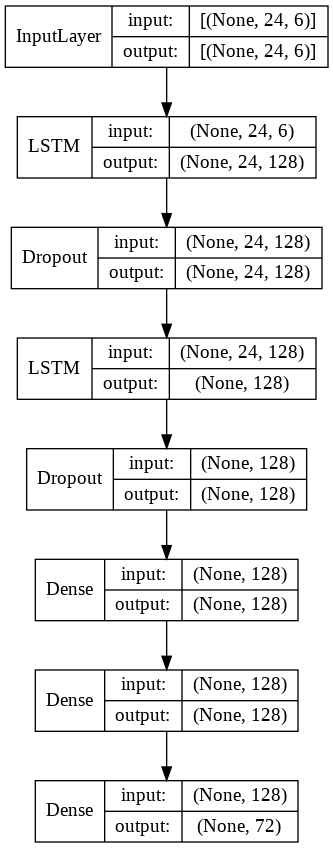

In [23]:
plot_model(model, show_shapes=True,show_layer_names=False)

In [31]:
seed(42)
tf.random.set_seed(42)

filepath="/content/weights.best.hdf5" #for print only best model

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, batch_size=128, epochs=40,validation_split=0.1, verbose=1, callbacks =callbacks_list)

Epoch 1/40
187/187 [==============================] - 33s 157ms/step - loss: 439.0425 - mse: 439.0425 - val_loss: 33.3820 - val_mse: 33.3820

Epoch 00001: val_loss improved from inf to 33.38205, saving model to /content/weights.best.hdf5
Epoch 2/40
187/187 [==============================] - 28s 148ms/step - loss: 114.8765 - mse: 114.8765 - val_loss: 30.9887 - val_mse: 30.9887

Epoch 00002: val_loss improved from 33.38205 to 30.98873, saving model to /content/weights.best.hdf5
Epoch 3/40
187/187 [==============================] - 28s 150ms/step - loss: 116.6829 - mse: 116.6829 - val_loss: 39.0658 - val_mse: 39.0658

Epoch 00003: val_loss did not improve from 30.98873
Epoch 4/40
187/187 [==============================] - 28s 150ms/step - loss: 113.8483 - mse: 113.8483 - val_loss: 26.8158 - val_mse: 26.8158

Epoch 00004: val_loss improved from 30.98873 to 26.81581, saving model to /content/weights.best.hdf5
Epoch 5/40
187/187 [==============================] - 28s 149ms/step - loss: 110.2

In [32]:
from google.colab import files
files.download('weights.best.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>